/opt/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


          Bezirk  district_id  Einwohner_ue59  Physicians  Physicians_per_1000
5   Innere_Stadt            1             993          39            39.274924
12   St_Leonhard            2            4022          56            13.923421
2        Geidorf            3            6334         119            18.787496
7           Lend            4            7497          46             6.135788
4          Gries            5            6680          24             3.592814
6       Jakomini            6            8351          43             5.149084
8       Liebenau            7            3779          24             6.350886
13      St_Peter            8            4284          28             6.535948
15    Waltendorf            9            3601          39            10.830325
11          Ries           10            1721          14             8.134805
9     Mariatrost           11            2554          20             7.830854
0        Andritz           12            5623       

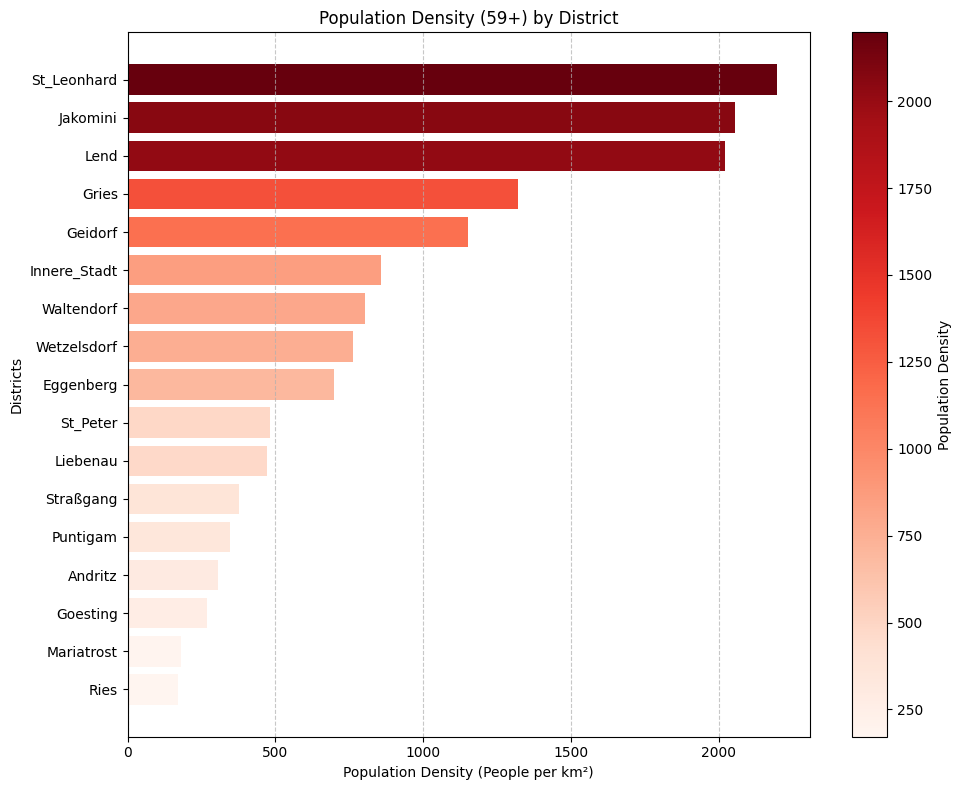

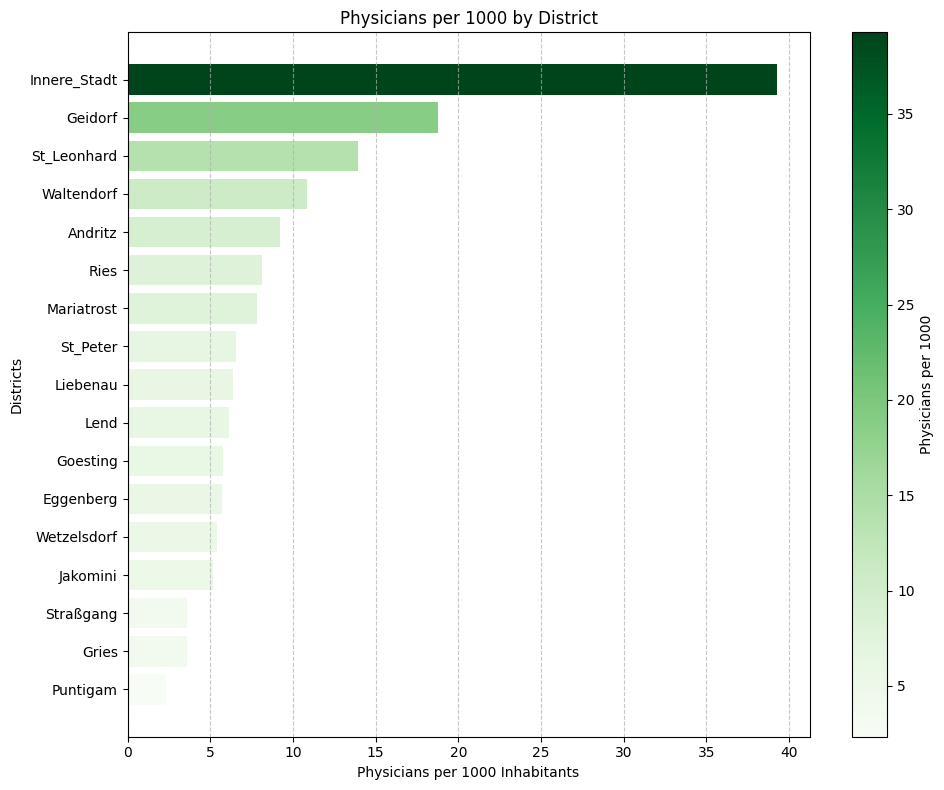

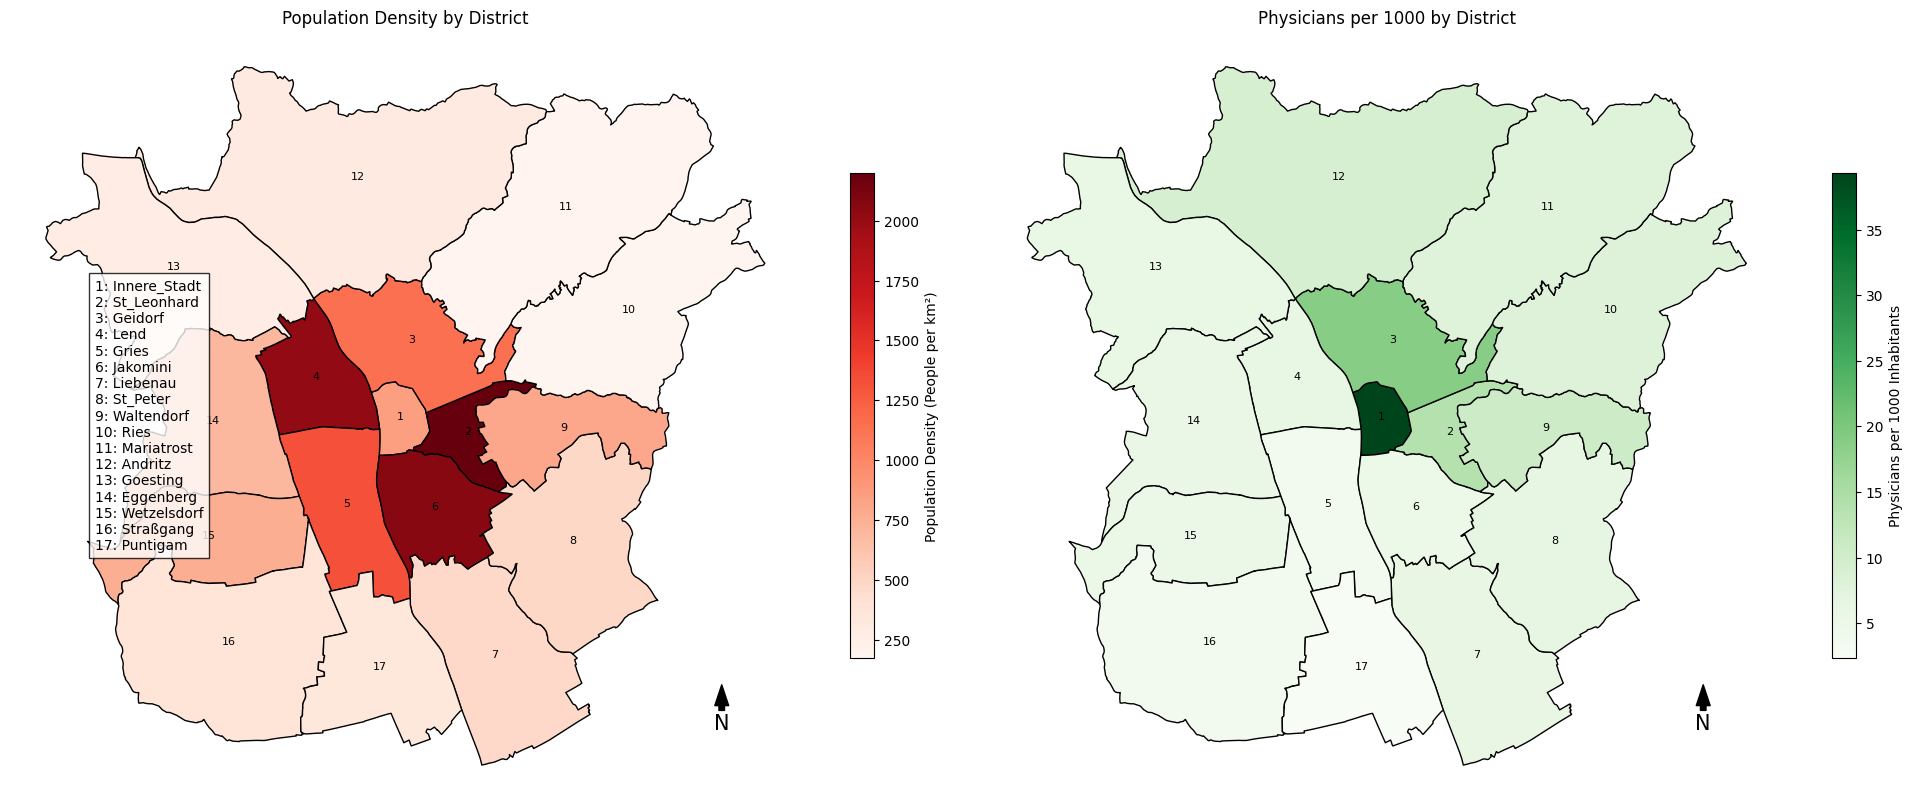

In [19]:
"""
------------------------------------------------------------------------------------------------------------------------
GST.200UB
GIS Analysetechniken 2
Winterterm 2024/2025
Midterm Project
Project Name: 
Name: Burgstaller Selina, Kirchmair Marco, Signitzer Benjamin
Matrnr.: 11909818,01319580,11742521
------------------------------------------------------------------------------------------------------------------------
########################################################################################################################
PART 1: Data Loading
########################################################################################################################
"""
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import cm, colors as mcolors

# Load population data from a CSV file
population_data = pd.read_csv("Bev_Graz_2023_ue59.csv", delimiter=";", encoding="latin1", header=0)

# Load physician data from a shapefile
physicians_data = gpd.read_file("AerztInnen.shp")

# Load district boundaries from a shapefile
districts_data = gpd.read_file("Graz_Stadtbezirke_UTM33N.shp")

"""
########################################################################################################################
PART 2: Data Preprocessing
########################################################################################################################
"""
# Spatial join to assign physicians to districts based on location
physicians_in_districts = gpd.sjoin(physicians_data, districts_data, how="inner", op="within")

# Count the number of physicians per district
physicians_count_per_district = physicians_in_districts.groupby('name_id').size().reset_index(name="Physicians")

# Map district names to unique numerical IDs
district_ids = {
    "Innere_Stadt": 1,
    "St_Leonhard": 2,
    "Geidorf": 3,
    "Lend": 4,
    "Gries": 5,
    "Jakomini": 6,
    "Liebenau": 7,
    "St_Peter": 8,
    "Waltendorf": 9,
    "Ries": 10,
    "Mariatrost": 11,
    "Andritz": 12,
    "Goesting": 13,
    "Eggenberg": 14,
    "Wetzelsdorf": 15,
    "Straßgang": 16,
    "Puntigam": 17
}

# Transform population data from wide to long format for easier processing
# https://www.delftstack.com/de/howto/python-pandas/reshape-pandas-data-frame-from-wide-to-long/
long_population_data = population_data.melt(
    id_vars=['Unnamed: 0'],  # Keep non-district-specific columns
    value_vars=list(district_ids.keys()),  # Columns with district names
    var_name='Bezirk',  # New column for district names
    value_name='Einwohner_ue59'  # New column for population data
)

# Map district names to their corresponding numerical IDs
long_population_data['district_id'] = long_population_data['Bezirk'].map(district_ids)

# Drop rows with missing values in the population data
long_population_data = long_population_data.dropna(subset=['Einwohner_ue59'])

# Group population data by district and sum up population numbers
population_per_district = (
    long_population_data.groupby(['Bezirk', 'district_id'])
    .agg({'Einwohner_ue59': 'sum'})
    .reset_index()
)

# Rename the district identifier in physician data for consistent merging
physicians_count_per_district = physicians_count_per_district.rename(columns={'name_id': 'district_id'})

"""
########################################################################################################################
PART 3: Data Merging and Calculations
########################################################################################################################
"""
# Merge population data with physician count data based on district ID
merged_data = pd.merge(
    population_per_district,
    physicians_count_per_district,
    how='inner',  # Keep only districts present in both datasets
    on='district_id'
)

# Calculate the number of physicians per 1000 inhabitants
merged_data['Physicians_per_1000'] = (merged_data['Physicians'] / merged_data['Einwohner_ue59']) * 1000

# Sort the merged data by district ID
sorted_data = merged_data.sort_values(by='district_id')

print(sorted_data)

# Ensure the district ID in the shapefile is numeric for merging
# https://www.delftstack.com/de/api/python-pandas/pandas-dataframe-dataframe.to_numeric-function/
districts_data['name_id'] = pd.to_numeric(districts_data['name_id'], errors='coerce')

# Merge the geographic district data with the sorted dataset
geo_merged_data = districts_data.merge(
    sorted_data,
    how='inner',  # Keep only matching districts
    left_on='name_id',
    right_on='district_id'
)

# Calculate population density as inhabitants per square kilometer
geo_merged_data['Population_Density'] = geo_merged_data['Einwohner_ue59'] / geo_merged_data['Area_km2']

"""
########################################################################################################################
PART 4: Visualization - Population Density
########################################################################################################################
"""
# Prepare data for visualizing population density
population_density_data = geo_merged_data[['Bezirk', 'Population_Density']].sort_values(by='Population_Density')

# Normalize values for color mapping in the chart
""""
CHATGPT PROMPT:
Write Python code to normalize a dataset for color mapping in a chart using Matplotlib. 
Normalize the values of a specific column, for example, 'Population_Density', to a range between the minimum and 
maximum values of that column.""" 

norm = mcolors.Normalize(vmin=population_density_data['Population_Density'].min(), 
                          vmax=population_density_data['Population_Density'].max())
colors = cm.Reds(norm(population_density_data['Population_Density']))

# Create a horizontal bar chart to visualize population density
fig, ax = plt.subplots(figsize=(10, 8))
bars = ax.barh(
    population_density_data['Bezirk'], 
    population_density_data['Population_Density'], 
    color=colors
)

# Add grid, labels, and title
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.set_xlabel('Population Density (People per km²)')
ax.set_ylabel('Districts')
ax.set_title('Population Density (59+) by District')

# Add a color bar for reference
sm = cm.ScalarMappable(cmap='Reds', norm=norm)
sm.set_array([])  # Placeholder array for ScalarMappable
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Population Density')

plt.tight_layout()
plt.show()

"""
########################################################################################################################
PART 5: Visualization - Physisicians per 1000
########################################################################################################################
"""
# Extract necessary columns for visualizing physicians per 1000 inhabitants
physicians_per_1000_data = geo_merged_data[['Bezirk', 'Physicians_per_1000']].sort_values(by='Physicians_per_1000')

# Normalize data for color mapping
norm = mcolors.Normalize(vmin=physicians_per_1000_data['Physicians_per_1000'].min(), 
                          vmax=physicians_per_1000_data['Physicians_per_1000'].max())
colors = cm.Greens(norm(physicians_per_1000_data['Physicians_per_1000']))

# Create horizontal bar chart with a gradient color
fig, ax = plt.subplots(figsize=(10, 8))
bars = ax.barh(
    physicians_per_1000_data['Bezirk'], 
    physicians_per_1000_data['Physicians_per_1000'], 
    color=colors
)

# Add grid, labels, and title
ax.grid(axis='x', linestyle='--', alpha=0.7)  # Add a grid on the x-axis
ax.set_xlabel('Physicians per 1000 Inhabitants')
ax.set_ylabel('Districts')
ax.set_title('Physicians per 1000 by District')

# Add color bar for reference
sm = cm.ScalarMappable(cmap='Greens', norm=norm)
sm.set_array([])  # Placeholder array for ScalarMappable
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Physicians per 1000')

plt.tight_layout()
plt.show()

"""
########################################################################################################################
PART 6: Thematic Maps
########################################################################################################################
"""
# Function to add a north arrow in the bottom-right corner of the map
"""
CHATGPT PROMPT:
Write a Python function to add a north arrow to a Matplotlib map."""

def add_north_arrow(ax, x=0.9, y=0.1, size=15):
    """
    Adds a north arrow to the map.

    Parameters:
    ax (matplotlib axis): The axis on which the arrow is drawn.
    x (float): Horizontal position of the arrow (relative to the axes fraction).
    y (float): Vertical position of the arrow (relative to the axes fraction).
    size (int): Font size for the "N" label.
    """
    ax.annotate(
        'N', 
        xy=(x, y + 0.05),  # Tip of the arrow
        xytext=(x, y),  # Base of the arrow
        arrowprops=dict(facecolor='black', width=4, headwidth=10, headlength=15),  # Arrow style
        ha='center', 
        va='center', 
        fontsize=size, 
        xycoords='axes fraction'
    )

# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Population Density Thematic Map
geo_merged_data.plot(
    column='Population_Density',
    cmap='Reds',
    legend=True,
    ax=axes[0],
    legend_kwds={'label': "Population Density (People per km²)", 'shrink': 0.5},
    edgecolor='black'
)
axes[0].set_title('Population Density by District')
axes[0].axis('off')  # Turn off axis for clean map visualization

# Add district numbers to Population Density Map
for idx, row in geo_merged_data.iterrows():
    axes[0].annotate(
        text=str(row['district_id']),  # Use district_id as the label
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        ha='center',
        fontsize=8,
        color='black'
    )

# Physicians per 1000 Thematic Map
geo_merged_data.plot(
    column='Physicians_per_1000',
    cmap='Greens',
    legend=True,
    ax=axes[1],
    legend_kwds={'label': "Physicians per 1000 Inhabitants", 'shrink': 0.5},
    edgecolor='black'
)
axes[1].set_title('Physicians per 1000 by District')
axes[1].axis('off')  # Turn off axis for clean map visualization

# Add district numbers to Physicians per 1000 Map
for idx, row in geo_merged_data.iterrows():
    axes[1].annotate(
        text=str(row['district_id']),  # Use district_id as the label
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        ha='center',
        fontsize=8,
        color='black'
    )

# Create a district overview (names and numbers)
district_table_data = geo_merged_data[['district_id', 'Bezirk']].sort_values(by='district_id')

# Add a text box for the district overview
table_text = "\n".join([f"{row['district_id']}: {row['Bezirk']}" for _, row in district_table_data.iterrows()])
fig.text(0.05, 0.5, table_text, fontsize=10, va='center', bbox=dict(facecolor='white', alpha=0.8))

# Add a north arrow to each subplot explicitly
add_north_arrow(axes[0])  # Add north arrow to the Population Density map
add_north_arrow(axes[1])  # Add north arrow to the Physicians per 1000 map

# Adjust layout
plt.tight_layout()
plt.show()

